# Project 3A: EDA and Data Cleaning

## 1. Executive Summary

Our goal for this analysis is somewhat open-ended. At the center of it is the concept of Natural Language Processing (NLP), which in the context of machine learning, calls for a model to process and fit on large amounts of human language data in order to make relevant conclusions. In our case, we are setting out to create an NLP Classifier fit on two distinct pages from Reddit. Our goal will be to create a model capable of accurately predicting to which subreddit a given post belongs, based on the diction used in that post. 

Our two chosen subreddits are r/PersonalFinance and r/Investing. These two pages share a number of similarities, particularly in their focus on financial concepts and money management, but they are naturally different in the scale and scope of discussions hosted. Investing generally tends to focus on public markets, firm decisions that affect markets and investment portfolios, etc. Personal Finance tends to host discussions more focused on individual financial questions and issues, with many related to things like taxes, savings accounts, career-related finances, etc. 

By training our NLP classifier on the linguistic content on each subreddit, we hope to build a model capable of distinguising between r/Investing and r/PersonalFinance effectively enough to predict where a theoretical new post would be best suited.

## 2. Imports and Read-In

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
import re

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
investing = pd.read_csv('./data/investing_20k.csv')
pfin = pd.read_csv('./data/personalfinance_20k.csv')

In [3]:
investing.drop(columns='Unnamed: 0',inplace=True)
pfin.drop(columns='Unnamed: 0',inplace=True)

In [4]:
investing.head()

,title,author,selftext,created_utc,subreddit
0,I think I got lucky with Corsair,code4109,Just started investing this month and this is ...,1601600412,investing
1,help please im noob,bugiii3,[removed],1601598645,investing
2,Why do stocks go up?,Illustrious-Twist-19,[removed],1601598583,investing
3,How do I set up an account?,GoISU25,I just recently downloaded Robinhood and have ...,1601597880,investing
4,Holding til things settle?,[deleted],[deleted],1601597840,investing


In [5]:
pfin.head()

,title,author,selftext,created_utc,subreddit
0,PA— I have to self quarantine for 14 days beca...,lemmelurkhoe,[removed],1601600107,personalfinance
1,Roth IRA Question,JoeMarine1,I opened a Roth IRA with M1 Finance. With M1 F...,1601600087,personalfinance
2,Refi 30y mortgage looks to good to be true.. w...,The-Dane,I saw another post and did not want to hijack ...,1601600014,personalfinance
3,"Still have not gotten my federal tax return, i...",pale_friend,This is my first time that I am supposed to ge...,1601600006,personalfinance
4,Medical coverage for international travel,Qwirkle2468,I'm not sure this is the right sub for this. M...,1601599701,personalfinance


## 3. Data Cleaning

#### Creating a Master DataFrame to Deal with [removed] and empty text together

In [6]:
master_df = pd.concat([investing,pfin],axis=0)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        40000 non-null  object
 1   author       40000 non-null  object
 2   selftext     39171 non-null  object
 3   created_utc  40000 non-null  int64 
 4   subreddit    40000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [7]:
master_df['subreddit'] = master_df['subreddit'].map({'investing':1,'personalfinance':0})

In [8]:
master_df['selftext'].fillna('NO_TEXT',inplace=True)

In [9]:
master_df['selftext'].replace('[removed]','NO_TEXT',inplace=True)

In [10]:
master_df['selftext'].replace('[deleted]','NO_TEXT',inplace=True)

##### Noticed a strange issue with processing ampersands for both subs, so I replaced them with 'and'. It seemed particularly important when dealing with mentions of the S&P index, which came up in both subs. In order to allow S&P to be vectorized as one word, I had to use 'and' instead of a regular '&'.

In [11]:
master_df['selftext'] = master_df['selftext'].str.replace('&amp;','and')
master_df['title'] = master_df['title'].str.replace('&amp;','and')

In [12]:
master_df[master_df['selftext'].str.contains('SandP')]
# Quick check to make sure S&P has been replaced the way that we want it; looks like it's good to go.

,title,author,selftext,created_utc,subreddit
63,Asset Allocation,MattBisc13,"Hello everyone, looking for advice. I am a 19 ...",1601557091,1
142,Bloomberg Terminal news question,macpad095,I got free access to a Bloomberg Terminal prov...,1601491711,1
263,28 years old. My financial advisor has been ho...,scratchgolfer17,Here is my plan:\n\n*Single-k 401k*\n\n**Curre...,1601405982,1
272,Dump my entire portfolio into clean energy ETF?,BigSadIdiot,Title. How good/bad of an idea is this?\n\nBac...,1601399195,1
332,Leveraged version of the SPY?,Godkingcoconut,Okay so we all know about the QQQ for the Nasd...,1601349781,1
...,...,...,...,...,...
18308,Help investing 20k in Charles Schwab mutual fu...,CommeDeuxGouttesDeau,I have saved 10k up in a emergency fund bank s...,1597806965,0
18528,How much should I be in investing? What should...,MooingComputer,After 5 years of my wife and I working our ass...,1597778594,0
18694,How does my portfolio look?,ToopLoopDoop,* Background\n * 19\n * Sophomore in colle...,1597759480,0
19076,Need advice picking 401k investment options,loose-leaf-paper,The new company I work for have given me a 401...,1597688840,0


#### Separating them back out to do some EDA on each and Finer Cleaning

In [13]:
investing_clean = master_df[master_df['subreddit']==1]
pfin_clean = master_df[master_df['subreddit']==0]

In [14]:
my_tokenizer = RegexpTokenizer("[a-zA-Z0-9\'?]+")

In [15]:
my_stop = ['no_text', '\n&gt;' ,'https', 'com', 'www', 'don']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop)

cvect = CountVectorizer(stop_words=stop_words,max_features=100)
tfidf = TfidfVectorizer(stop_words=stop_words)

#### Grabbing the Top 20 words in each sub, will represent visually later

In [16]:
dtm_inv = cvect.fit_transform(investing_clean['selftext'])
dtm_inv = pd.DataFrame(dtm_inv.toarray(),columns=cvect.get_feature_names())

inv_top_20 = pd.DataFrame(dtm_inv.sum().nlargest(20))

C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [17]:
dtm_pfin = cvect.fit_transform(pfin_clean['selftext'])
dtm_pfin = pd.DataFrame(dtm_pfin.toarray(),columns=cvect.get_feature_names())

pfin_top_20 = pd.DataFrame(dtm_pfin.sum().nlargest(20))

##### It is worth noting that there were many more blank selftext's in the sample of the investing subreddit's posts when compared to the personal finance sample:

In [18]:
investing_clean['selftext'].value_counts(ascending=False)[0]

8253

In [19]:
pfin_clean['selftext'].value_counts(ascending=False)[0]

3635

#### Exporting back into a CSV to use later for Modeling

In [20]:
master_df = pd.concat([investing_clean,pfin_clean])

In [21]:
master_df.to_csv('./master_df.csv')

## 4. Relevant Visualizations

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


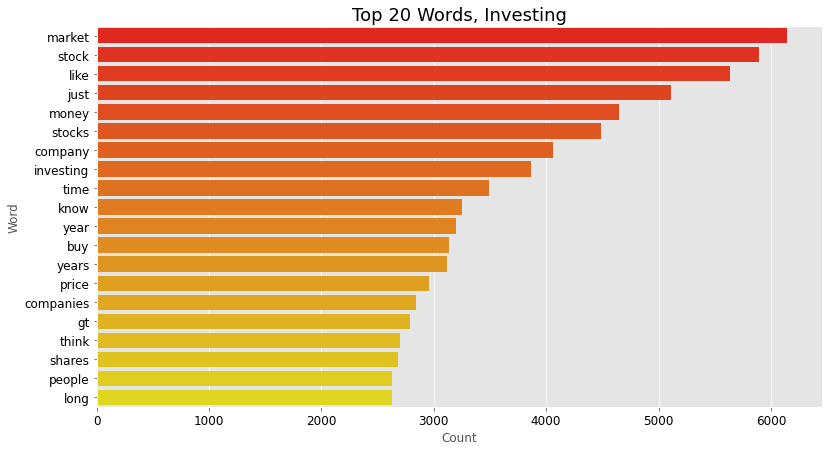

In [22]:
plt.figure(figsize = (13,7))
plt.title('Top 20 Words, Investing',fontsize=18)
g = sns.barplot(inv_top_20[0],inv_top_20.index, palette='autumn')
g.set_yticklabels(g.get_yticklabels(),fontweight=50,fontsize=10)
g.set(ylabel='Word')
g.set(xlabel='Count')
g.tick_params(labelsize=12,labelcolor='black')

These words are looking intuitively related to investing and larger-scale financial concepts. This is a good indicator that our scrape worked relatively well and we're not seeing anything crazy or unexpeted for this subreddit.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


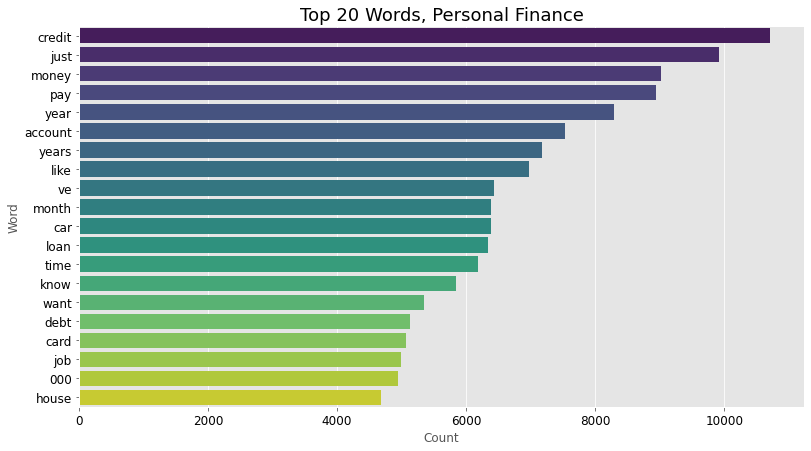

In [35]:
plt.figure(figsize = (13,7))
plt.title('Top 20 Words, Personal Finance',fontsize=18)
g = sns.barplot(pfin_top_20[0],pfin_top_20.index, palette='viridis')
g.set_yticklabels(g.get_yticklabels(),fontweight=50,fontsize=10)
g.set(ylabel='Word')
g.set(xlabel='Count')
g.tick_params(labelsize=12,labelcolor='black')

Similarly, the words here are more closely aligned with smaller scale, individual financial concepts which is a good sign for our scrape here as well.

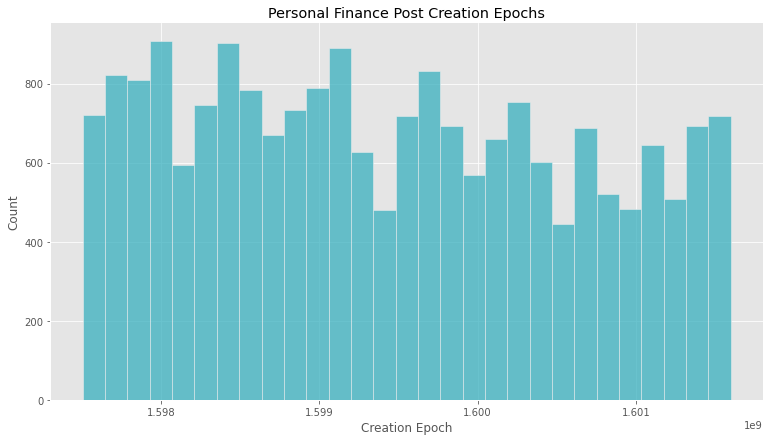

In [62]:
h = sns.displot(pfin_clean['created_utc'],kde=False,height=6,aspect=1.8,color='#39B0BF');
h.set(title='Personal Finance Post Creation Epochs')
h.set(ylabel='Count')
h.set(xlabel='Creation Epoch')

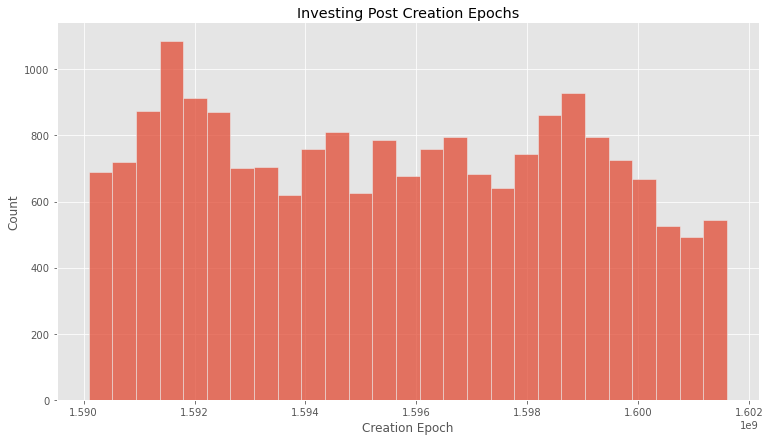

In [63]:
j = sns.displot(investing_clean['created_utc'],kde=False,height=6,aspect=1.8);
j.set(title='Investing Post Creation Epochs')
j.set(ylabel='Count')
j.set(xlabel='Creation Epoch')

There seems to be a slightly larger time range for 20,000 posts in the Investing subreddit when compared to the Personal Finance subreddit. This makes sense intuitively, as the Investing subreddit has many fewer members at 1.2 million, than Personal Finance, which has nearly 15 million; and the latter has posts more frequently. This accounts for the fact that 20,000 posts spanned a shorter amount of time for Personal Finance than it did for Investing.